In [14]:
import torch
import os
import numpy as np
import pandas as pd
from utils import modify_metadata, TARGETS
from input_utils import TrainDataset
from model import EnsembleModel, LinearModel
from training import train, CV_score
import matplotlib.pyplot as plt


In [15]:
TRAIN_METADATA_DIR = "../../data/train.csv"
TRAIN_SIGNATURES_DIR = "../../data/train_signatures/"
train_metadata = pd.read_csv(TRAIN_METADATA_DIR)
train_metadata = modify_metadata(train_metadata)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = torch.nn.KLDivLoss(reduction='batchmean')

In [16]:
# add a weight column to the metadata
weight = 1/train_metadata.target.value_counts()
target_names = {'Seizure': 'seizure_vote', 'LPD': 'lpd_vote', 'GPD': 'gpd_vote', 'LRDA': 'lrda_vote', 'GRDA': 'grda_vote', 'Other': 'other_vote'}
train_metadata['weight'] = train_metadata.apply(lambda x: weight[x['target']], axis=1)

In [17]:
train_metadata

,eeg_id,spectrogram_id,eeg_offset_seconds,spec_offset_seconds,patient_id,target,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,weight
0,568657,789577333,9.0,9.0,20654,Other,0.000000,0.000000,0.250000,0.000000,0.166667,0.583333,0.000328
1,582999,1552638400,18.0,18.0,20230,LPD,0.000000,0.857143,0.000000,0.071429,0.000000,0.071429,0.000866
2,1895581,128369999,0.0,1138.0,47999,Other,0.076923,0.000000,0.000000,0.000000,0.076923,0.846154,0.000328
3,2482631,978166025,24.0,1926.0,20606,Other,0.000000,0.000000,0.133333,0.066667,0.133333,0.666667,0.000328
4,2521897,673742515,2.0,2.0,62117,Other,0.000000,0.000000,0.083333,0.083333,0.333333,0.500000,0.000328
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5934,4291430584,1984115527,15.0,565.0,61174,LPD,0.000000,0.687500,0.000000,0.000000,0.000000,0.312500,0.000866
5935,4291744526,677970444,14.0,14.0,15506,GRDA,0.000000,0.125000,0.000000,0.000000,0.500000,0.375000,0.002336
5936,4292809326,75243787,12.0,12.0,18815,Other,0.000000,0.000000,0.000000,0.000000,0.083333,0.916667,0.000328
5937,4293306306,819682076,0.0,168.0,37409,GPD,0.000000,0.066667,0.400000,0.000000,0.133333,0.400000,0.001342


In [18]:
TARGETS

['seizure_vote',
 'lpd_vote',
 'gpd_vote',
 'lrda_vote',
 'grda_vote',
 'other_vote']

In [32]:
# hyperparameters 
signature_level = 4
lr = 0.0007425105458353962
weight_decay = 3.305710445615262e-05
dropout = 0.5
early_stopping_epochs = 60
classifier_input_dim = 256
scaler_type = "meanvar_1.0"
logsigs_or_sigs = "sigs"
hidden_layer_dim = 128

In [33]:
TRAIN_SIGNATURES_FILE = f"{TRAIN_SIGNATURES_DIR}all_{logsigs_or_sigs}_lvl_{signature_level}_scaler_{scaler_type}_experts.pt"
signature_features = torch.load(TRAIN_SIGNATURES_FILE)
dataset = TrainDataset(train_metadata, signature_features)

In [34]:
# train test split
fold_size = len(dataset) // 5
train_dataset = torch.utils.data.Subset(dataset, list(range(fold_size, len(dataset))))
test_dataset = torch.utils.data.Subset(dataset, list(range(fold_size)))

sampler = torch.utils.data.WeightedRandomSampler(train_metadata.weight[fold_size:].to_numpy(), len(train_metadata[fold_size:]), replacement=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, sampler=sampler)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=fold_size, shuffle=False)
sig_dimension = dataset[0][0].shape[1]

In [35]:
ensemble_model = EnsembleModel(sig_dimension, dropout, classifier_input_dim, hidden_layer_dim)
optimizer = torch.optim.Adam(ensemble_model.parameters(), lr=lr, weight_decay=weight_decay)
train_losses, test_losses, model = train(ensemble_model, train_loader, test_loader, device, criterion, optimizer, early_stopping_epochs, max_epochs=100)

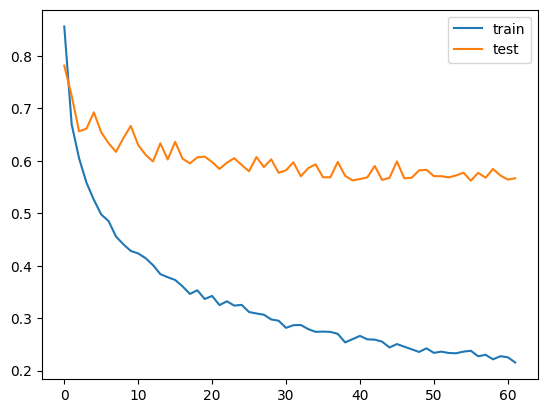

In [36]:
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.legend()

In [37]:
test_losses

[0.7812510132789612,
 0.7241982817649841,
 0.656089723110199,
 0.660923957824707,
 0.6922322511672974,
 0.6541274785995483,
 0.633381187915802,
 0.6168766021728516,
 0.6431378722190857,
 0.666246771812439,
 0.6300222277641296,
 0.6113163828849792,
 0.5985385775566101,
 0.6330904364585876,
 0.6023076176643372,
 0.6360630393028259,
 0.6039254069328308,
 0.5949317216873169,
 0.6064963340759277,
 0.6079056262969971,
 0.5974909663200378,
 0.5843586325645447,
 0.596311628818512,
 0.6047910451889038,
 0.5918744206428528,
 0.5799347162246704,
 0.6069766879081726,
 0.5879344344139099,
 0.6025676131248474,
 0.5768355131149292,
 0.581798791885376,
 0.5970345735549927,
 0.5703412890434265,
 0.5858670473098755,
 0.5930780172348022,
 0.5685036182403564,
 0.56836998462677,
 0.5976380109786987,
 0.571199357509613,
 0.5624871253967285,
 0.5651075839996338,
 0.5682101845741272,
 0.5900372266769409,
 0.5634053945541382,
 0.5673766732215881,
 0.598659873008728,
 0.5665162801742554,
 0.5675603151321411,
 0

In [12]:
# CV scores for each interval
TRAIN_SIGNATURES_FILE = f"{TRAIN_SIGNATURES_DIR}all_{logsigs_or_sigs}_lvl_{signature_level}_scaler_{scaler_type}_experts.pt"
signature_features = torch.load(TRAIN_SIGNATURES_FILE)
dataset = TrainDataset(train_metadata, signature_features)
scores, train_losses, test_losses = CV_score(dataset, list(train_metadata.weight), lr, weight_decay, dropout, classifier_input_dim, hidden_layer_dim, device, criterion, early_stopping_epochs)

In [13]:
scores

[0.5412033200263977,
 0.5437892079353333,
 0.55637526512146,
 0.5179111361503601,
 0.5126037001609802]